# Brain tumor 3D segmentation with MONAI

This tutorial shows how to construct a training workflow of multi-labels segmentation task.  
And it contains below features:
1. Transforms for dictionary format data.
2. Define a new transform according to MONAI transform API.
3. Load Nifti image with metadata, load a list of images and stack them.
4. Randomly adjust intensity for data augmentation.
5. Cache IO and transforms to accelerate training and validation.
6. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
7. Deterministic training for reproducibility.

The Brain tumor dataset can be downloaded from http://medicaldecathlon.com/.
![Tumor](http://medicaldecathlon.com/img/Tumour.png)  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
from monai.transforms import \
    MapTransform, Compose, LoadNiftid, AsChannelFirstd, Spacingd, Orientationd, \
    RandSpatialCropd, RandFlipd, NormalizeIntensityd, RandScaleIntensityd, \
    RandShiftIntensityd, CenterSpatialCropd, ToTensord
from monai.data import DataLoader
from monai.apps import DecathlonDataset
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism

## Set deterministic training for reproducibility

In [2]:
set_determinism(seed=0)

## Define a new transform to convert brain tumor labels
Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [3]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WC (Whole tumor)
    and ET (Enhancing tumor).

    """
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = list()
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WC
            result.append(np.logical_or(np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

## Setup transforms for training and validation

In [4]:
train_transform = Compose([
    # load 4 Nifti images and stack them together
    LoadNiftid(keys=['image', 'label']),
    AsChannelFirstd(keys='image'),
    ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
    Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), mode=('bilinear', 'nearest')),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    RandSpatialCropd(keys=['image', 'label'], roi_size=[128, 128, 64], random_size=False),
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=0),
    NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
    RandScaleIntensityd(keys='image', factors=0.1, prob=0.5),
    RandShiftIntensityd(keys='image', offsets=0.1, prob=0.5),
    ToTensord(keys=['image', 'label'])
])
val_transform = Compose([
    LoadNiftid(keys=['image', 'label']),
    AsChannelFirstd(keys='image'),
    ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
    Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), mode=('bilinear', 'nearest')),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    CenterSpatialCropd(keys=['image', 'label'], roi_size=[128, 128, 64]),
    NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
    ToTensord(keys=['image', 'label'])
])

## Quickly load data with DecathlonDataset
Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, so we set `cache_num=100` to cache 100 items for training and use the defaut args to cache all the items for validation.

In [5]:
root_dir = '/workspace/data/medical'
train_ds = DecathlonDataset(root_dir=root_dir, task="Task01_BrainTumour", transform=train_transform,
                            section="training", download=True, num_workers=4, cache_num=100)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)
val_ds = DecathlonDataset(root_dir=root_dir, task="Task01_BrainTumour", transform=val_transform,
                          section="validation", download=False, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4)

file /workspace/data/medical/Task01_BrainTumour.tar exists, skip downloading.
extracted file /workspace/data/medical/Task01_BrainTumour exists, skip extracting.
100/100 Load and cache transformed data:  [==============================]
98/98 Load and cache transformed data:  [==============================]


## Check data shape and visualize

image shape: torch.Size([4, 128, 128, 64])


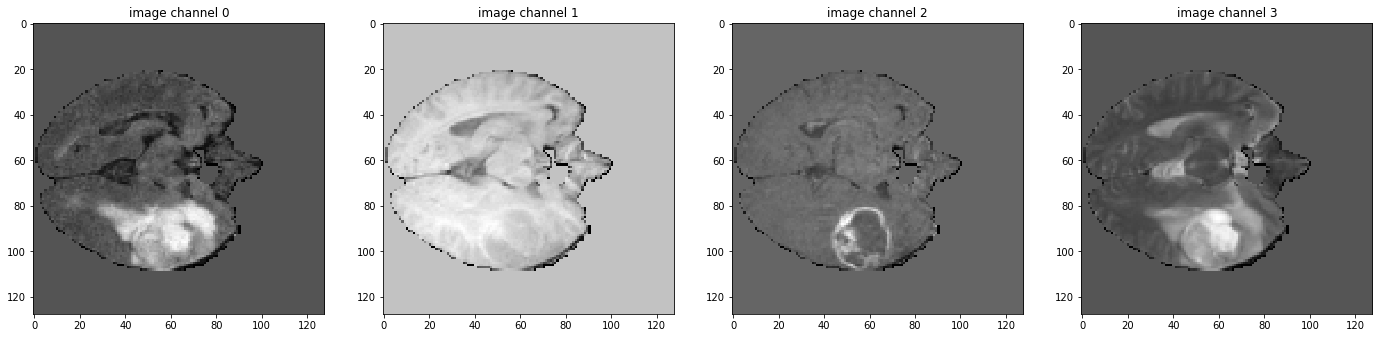

label shape: torch.Size([3, 128, 128, 64])


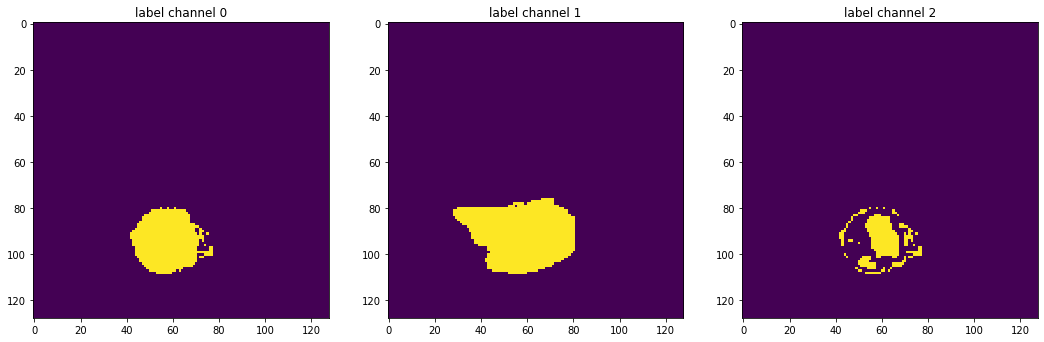

In [6]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
print(f"image shape: {val_ds[9]['image'].shape}")
plt.figure('image', (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title('image channel ' + str(i))
    plt.imshow(val_ds[9]['image'][i, :, :, 20].detach().cpu(), cmap='gray')
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_ds[9]['label'].shape}")
plt.figure('label', (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title('label channel ' + str(i))
    plt.imshow(val_ds[9]['label'][i, :, :, 20].detach().cpu())
plt.show()

## Create Model, Loss, Optimizer

In [7]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device('cuda:0')
model = UNet(dimensions=3, in_channels=4, out_channels=3, channels=(16, 32, 64, 128, 256),
             strides=(2, 2, 2, 2), num_res_units=2).to(device)
loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5, amsgrad=True)

## Execute a typical PyTorch training process

In [8]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
for epoch in range(10):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch + 1, 10))
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print('{}/{}, train_loss: {:.4f}'.format(step, len(train_ds) // train_loader.batch_size, loss.item()))
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print('epoch {} average loss: {:.4f}'.format(epoch + 1, epoch_loss))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=True, sigmoid=True, reduction="mean")
            metric_sum = metric_sum_tc = metric_sum_wt = metric_sum_et = 0.
            metric_count = metric_count_tc = metric_count_wt = metric_count_et = 0
            for val_data in val_loader:
                val_inputs, val_labels = val_data['image'].to(device), val_data['label'].to(device)
                val_outputs = model(val_inputs)
                # compute overall mean dice
                value = dice_metric(y_pred=val_outputs, y=val_labels)
                not_nans = dice_metric.not_nans.item()
                metric_count += not_nans
                metric_sum += value.item() * not_nans
                # compute mean dice for TC
                value_tc = dice_metric(y_pred=val_outputs[:, 0 : 1], y=val_labels[:, 0 : 1])
                not_nans = dice_metric.not_nans.item()
                metric_count_tc += not_nans
                metric_sum_tc += value_tc.item() * not_nans
                # compute mean dice for WT
                value_wt = dice_metric(y_pred=val_outputs[:, 1 : 2], y=val_labels[:, 1 : 2])
                not_nans = dice_metric.not_nans.item()
                metric_count_wt += not_nans
                metric_sum_wt += value_wt.item() * not_nans
                # compute mean dice for ET
                value_et = dice_metric(y_pred=val_outputs[:, 2 : 3], y=val_labels[:, 2 : 3])
                not_nans = dice_metric.not_nans.item()
                metric_count_et += not_nans
                metric_sum_et += value_et.item() * not_nans
                
            metric = metric_sum / metric_count
            metric_values.append(metric)
            metric_tc = metric_sum_tc / metric_count_tc
            metric_wt = metric_sum_wt / metric_count_wt
            metric_et = metric_sum_et / metric_count_et
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print('current epoch {} current mean dice: {:.4f} tc: {:.4f} wt: {:.4f} et: {:.4f}'.format(
                epoch + 1, metric, metric_tc, metric_wt, metric_et))
            print('best mean dice: {:.4f} at epoch {}'.format(best_metric, best_metric_epoch))

----------
Epoch 1/10
1/193, train_loss: 0.9586
2/193, train_loss: 0.9527
3/193, train_loss: 0.9456
4/193, train_loss: 0.9557
5/193, train_loss: 0.9427
6/193, train_loss: 0.9785
7/193, train_loss: 0.9714
8/193, train_loss: 0.9454
9/193, train_loss: 0.9821
10/193, train_loss: 0.9332
11/193, train_loss: 0.9722
12/193, train_loss: 0.9127
13/193, train_loss: 0.9220
14/193, train_loss: 0.9529
15/193, train_loss: 0.9384
16/193, train_loss: 0.9756
17/193, train_loss: 0.9184
18/193, train_loss: 0.9559
19/193, train_loss: 0.9788
20/193, train_loss: 0.9367
21/193, train_loss: 0.9090
22/193, train_loss: 0.9704
23/193, train_loss: 0.9534
24/193, train_loss: 0.9276
25/193, train_loss: 0.9564
26/193, train_loss: 0.9193
27/193, train_loss: 0.9699
28/193, train_loss: 0.9310
29/193, train_loss: 0.9052
30/193, train_loss: 0.9030
31/193, train_loss: 0.9605
32/193, train_loss: 0.8909
33/193, train_loss: 0.9260
34/193, train_loss: 0.9073
35/193, train_loss: 0.9723
36/193, train_loss: 0.8952
37/193, train_l

107/193, train_loss: 0.9432
108/193, train_loss: 0.9285
109/193, train_loss: 0.8775
110/193, train_loss: 0.9563
111/193, train_loss: 0.8929
112/193, train_loss: 0.9723
113/193, train_loss: 0.9331
114/193, train_loss: 0.9622
115/193, train_loss: 0.9414
116/193, train_loss: 0.9417
117/193, train_loss: 0.9032
118/193, train_loss: 0.9113
119/193, train_loss: 0.8900
120/193, train_loss: 0.9394
121/193, train_loss: 0.9204
122/193, train_loss: 0.9417
123/193, train_loss: 0.9126
124/193, train_loss: 0.9362
125/193, train_loss: 0.8945
126/193, train_loss: 0.8924
127/193, train_loss: 0.9167
128/193, train_loss: 0.9771
129/193, train_loss: 0.8847
130/193, train_loss: 0.8459
131/193, train_loss: 0.8568
132/193, train_loss: 0.9604
133/193, train_loss: 0.9233
134/193, train_loss: 0.9178
135/193, train_loss: 0.9656
136/193, train_loss: 0.8635
137/193, train_loss: 0.9392
138/193, train_loss: 0.8682
139/193, train_loss: 0.9454
140/193, train_loss: 0.8748
141/193, train_loss: 0.9150
142/193, train_loss:

11/193, train_loss: 0.9280
12/193, train_loss: 0.9575
13/193, train_loss: 0.9034
14/193, train_loss: 0.9712
15/193, train_loss: 0.9170
16/193, train_loss: 0.9028
17/193, train_loss: 0.9099
18/193, train_loss: 0.9660
19/193, train_loss: 0.9726
20/193, train_loss: 0.9137
21/193, train_loss: 0.9227
22/193, train_loss: 0.8153
23/193, train_loss: 0.9652
24/193, train_loss: 0.8403
25/193, train_loss: 0.9000
26/193, train_loss: 0.8923
27/193, train_loss: 0.8625
28/193, train_loss: 0.9014
29/193, train_loss: 0.8960
30/193, train_loss: 0.9280
31/193, train_loss: 0.8781
32/193, train_loss: 0.9371
33/193, train_loss: 0.8927
34/193, train_loss: 0.9561
35/193, train_loss: 0.9259
36/193, train_loss: 0.9336
37/193, train_loss: 0.9017
38/193, train_loss: 0.9302
39/193, train_loss: 0.9201
40/193, train_loss: 0.8969
41/193, train_loss: 0.9013
42/193, train_loss: 0.9035
43/193, train_loss: 0.8558
44/193, train_loss: 0.9295
45/193, train_loss: 0.8289
46/193, train_loss: 0.8577
47/193, train_loss: 0.9518
4

111/193, train_loss: 0.9016
112/193, train_loss: 0.8826
113/193, train_loss: 0.9409
114/193, train_loss: 0.8616
115/193, train_loss: 0.8972
116/193, train_loss: 0.9363
117/193, train_loss: 0.8491
118/193, train_loss: 0.9270
119/193, train_loss: 0.8057
120/193, train_loss: 0.9056
121/193, train_loss: 0.9297
122/193, train_loss: 0.9463
123/193, train_loss: 0.9584
124/193, train_loss: 0.8692
125/193, train_loss: 0.7482
126/193, train_loss: 0.9084
127/193, train_loss: 0.7532
128/193, train_loss: 0.9051
129/193, train_loss: 0.8721
130/193, train_loss: 0.9168
131/193, train_loss: 0.8269
132/193, train_loss: 0.8123
133/193, train_loss: 0.8348
134/193, train_loss: 0.8590
135/193, train_loss: 0.8788
136/193, train_loss: 0.8552
137/193, train_loss: 0.8742
138/193, train_loss: 0.8105
139/193, train_loss: 0.8316
140/193, train_loss: 0.9671
141/193, train_loss: 0.9218
142/193, train_loss: 0.7630
143/193, train_loss: 0.8310
144/193, train_loss: 0.8765
145/193, train_loss: 0.7835
146/193, train_loss:

14/193, train_loss: 0.9029
15/193, train_loss: 0.7961
16/193, train_loss: 0.8803
17/193, train_loss: 0.8892
18/193, train_loss: 0.9440
19/193, train_loss: 0.7533
20/193, train_loss: 0.8140
21/193, train_loss: 0.8139
22/193, train_loss: 0.8001
23/193, train_loss: 0.8638
24/193, train_loss: 0.7074
25/193, train_loss: 0.8007
26/193, train_loss: 0.7478
27/193, train_loss: 0.8554
28/193, train_loss: 0.9102
29/193, train_loss: 0.8699
30/193, train_loss: 0.8246
31/193, train_loss: 0.8659
32/193, train_loss: 0.8615
33/193, train_loss: 0.8694
34/193, train_loss: 0.8253
35/193, train_loss: 0.8268
36/193, train_loss: 0.6282
37/193, train_loss: 0.7278
38/193, train_loss: 0.8912
39/193, train_loss: 0.8183
40/193, train_loss: 0.7513
41/193, train_loss: 0.7165
42/193, train_loss: 0.8483
43/193, train_loss: 0.8774
44/193, train_loss: 0.7696
45/193, train_loss: 0.8393
46/193, train_loss: 0.8571
47/193, train_loss: 0.8312
48/193, train_loss: 0.9550
49/193, train_loss: 0.8161
50/193, train_loss: 0.7889
5

119/193, train_loss: 0.8352
120/193, train_loss: 0.8283
121/193, train_loss: 0.7816
122/193, train_loss: 0.8278
123/193, train_loss: 0.8540
124/193, train_loss: 0.6849
125/193, train_loss: 0.8535
126/193, train_loss: 0.8853
127/193, train_loss: 0.8082
128/193, train_loss: 0.7378
129/193, train_loss: 0.7607
130/193, train_loss: 0.7780
131/193, train_loss: 0.8343
132/193, train_loss: 0.7351
133/193, train_loss: 0.8234
134/193, train_loss: 0.6957
135/193, train_loss: 0.7143
136/193, train_loss: 0.8404
137/193, train_loss: 0.7902
138/193, train_loss: 0.7257
139/193, train_loss: 0.7475
140/193, train_loss: 0.9253
141/193, train_loss: 0.7594
142/193, train_loss: 0.8538
143/193, train_loss: 0.7311
144/193, train_loss: 0.6891
145/193, train_loss: 0.8856
146/193, train_loss: 0.8533
147/193, train_loss: 0.8364
148/193, train_loss: 0.7628
149/193, train_loss: 0.8114
150/193, train_loss: 0.7059
151/193, train_loss: 0.8415
152/193, train_loss: 0.6831
153/193, train_loss: 0.8287
154/193, train_loss:

23/193, train_loss: 0.5060
24/193, train_loss: 0.7413
25/193, train_loss: 0.7706
26/193, train_loss: 0.7215
27/193, train_loss: 0.6652
28/193, train_loss: 0.6800
29/193, train_loss: 0.7468
30/193, train_loss: 0.7683
31/193, train_loss: 0.6617
32/193, train_loss: 0.8098
33/193, train_loss: 0.7919
34/193, train_loss: 0.7159
35/193, train_loss: 0.6392
36/193, train_loss: 0.6367
37/193, train_loss: 0.8529
38/193, train_loss: 0.6835
39/193, train_loss: 0.8125
40/193, train_loss: 0.8590
41/193, train_loss: 0.6137
42/193, train_loss: 0.5829
43/193, train_loss: 0.6225
44/193, train_loss: 0.7649
45/193, train_loss: 0.6894
46/193, train_loss: 0.7606
47/193, train_loss: 0.8007
48/193, train_loss: 0.8990
49/193, train_loss: 0.7953
50/193, train_loss: 0.7471
51/193, train_loss: 0.7069
52/193, train_loss: 0.6772
53/193, train_loss: 0.7427
54/193, train_loss: 0.6953
55/193, train_loss: 0.7852
56/193, train_loss: 0.7025
57/193, train_loss: 0.4321
58/193, train_loss: 0.9502
59/193, train_loss: 0.6767
6

In [9]:
print('train completed, best_metric: {:.4f}  at epoch: {}'.format(best_metric, best_metric_epoch))

train completed, best_metric: 0.1248  at epoch: 10


## Plot the loss and metric

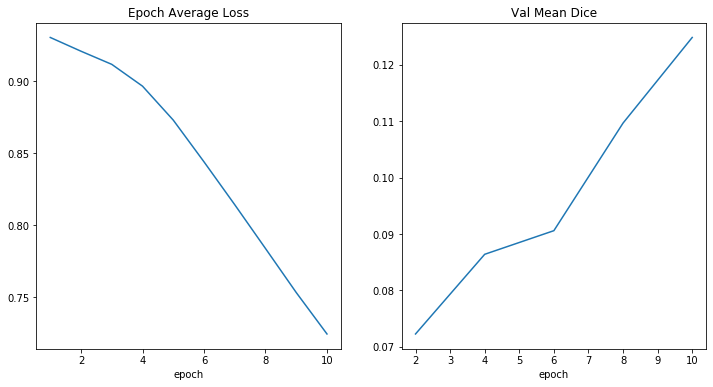

In [10]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title('Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title('Val Mean Dice')
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

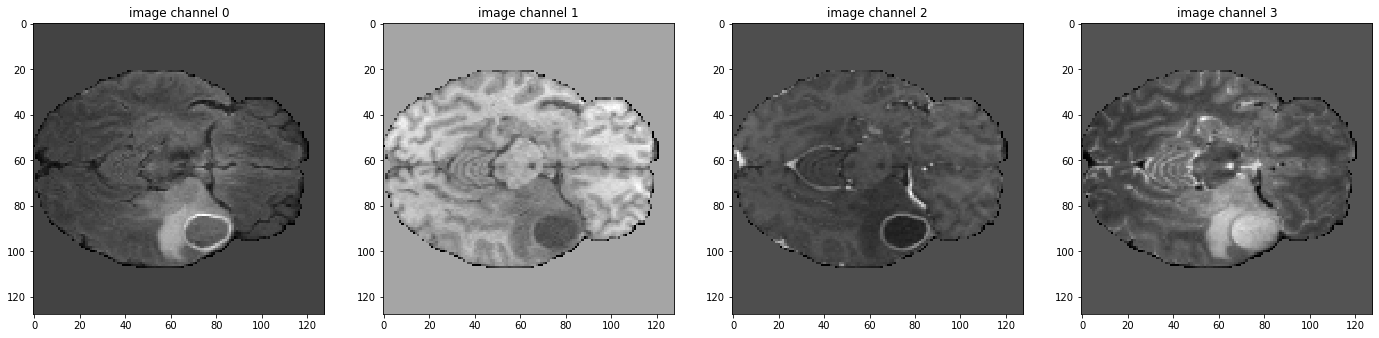

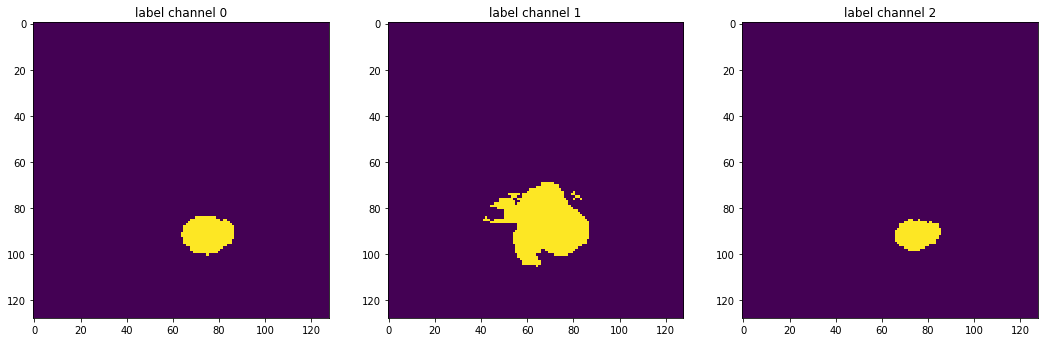

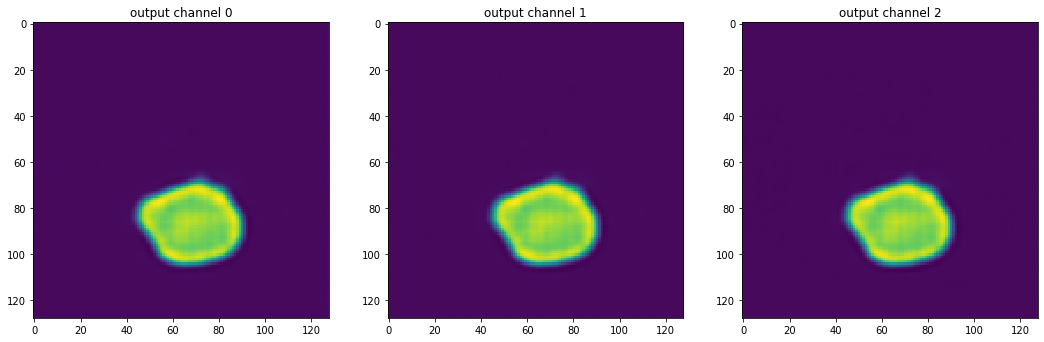

In [11]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]['image'].unsqueeze(0).to(device)
    val_output = model(val_input)
    plt.figure('image', (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title('image channel ' + str(i))
        plt.imshow(val_ds[6]['image'][i, :, :, 20].detach().cpu(), cmap='gray')
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure('label', (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title('label channel ' + str(i))
        plt.imshow(val_ds[6]['label'][i, :, :, 20].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure('output', (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title('output channel ' + str(i))
        plt.imshow(val_output[0, i, :, :, 20].detach().cpu())
    plt.show()